## Loss for W GAN

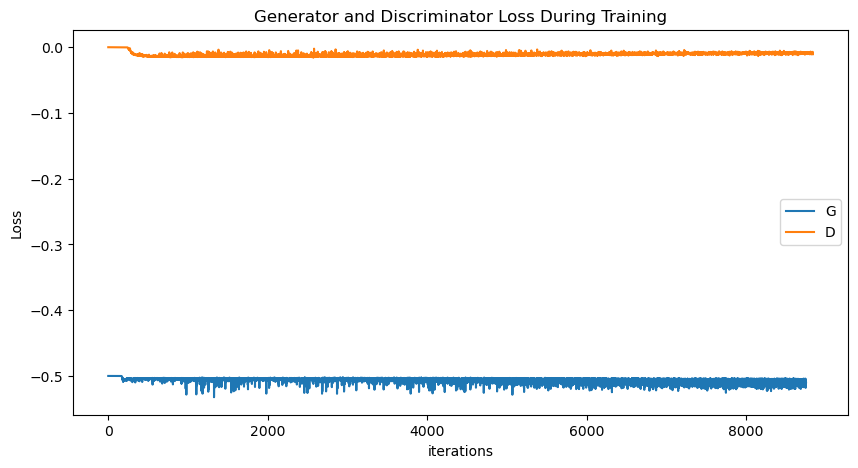
## FID for W-GAN
100%|██████████| 3/3 [00:01<00:00,  1.98it/s]
100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
Epoch [99/100], FID: 201

## Generated images with W-GAN

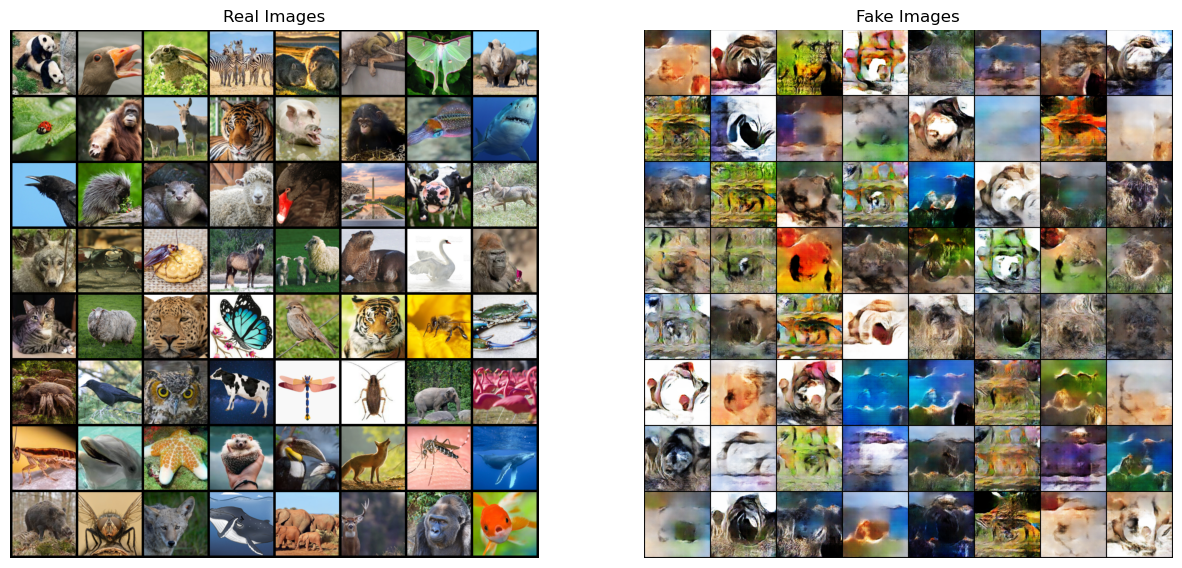



# Inference
FID with W-GAN is lesser than that of Vanilla DC-GAN, which is visible from the generated images

# Decoder class

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64 (generated image)
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size. (ngf) x 32 x 32
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size. (ngf*2) x 16 x 16
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size. (ngf*4) x 8 x 8
            nn.Conv2d(ngf * 4, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size. (ngf*8) x 4 x 4
            nn.Conv2d(ngf * 8, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            # Final layer: (ngf*16) x 1 x 1 -> Output size should match the latent vector Z
            nn.Conv2d(ngf * 16, nz, 4, 1, 0, bias=False),
            nn.Tanh()  # Use Tanh to match the latent vector distribution
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the Discriminator
netDecoder = Decoder(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

optimizerDecoder = optim.RMSprop(netDecoder.parameters(), lr=lrg)

Decoder(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Conv2d(2048, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (16): Tanh()
  )
)


# Training with Decoder

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Decoder_losses = []
fid_scores = []
iters = 0

def save_checkpoint(epoch, netG, netD, netDecoder, optimizerG, 
                    optimizerD, optimizerDecoder, G_losses, D_losses, Decoder_losses, 
                    fid_scores, iters, path='./checkpoint_dcgan_with_decoder_100_weight.pth'):
    state = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'netDecoder_state_dict': netDecoder.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'optimizerDecoder_state_dict': optimizerDecoder.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'Decoder_losses': Decoder_losses,
        'fid_scores': fid_scores,
        'iters': iters
    }
    torch.save(state, path)
    print(f'Checkpoint saved at epoch {epoch}, iteration {iters}')

def load_checkpoint(netG, netD, netDecoder, optimizerG, 
                    optimizerD, optimizerDecoder, 
                    path='./checkpoint_dcgan_with_decoder_100_weight.pth'):
    if os.path.exists(path):
        state = torch.load(path)
        netG.load_state_dict(state['netG_state_dict'])
        netD.load_state_dict(state['netD_state_dict'])
        netDecoder.load_state_dict(state['netDecoder_state_dict'])
        optimizerG.load_state_dict(state['optimizerG_state_dict'])
        optimizerD.load_state_dict(state['optimizerD_state_dict'])
        optimizerDecoder.load_state_dict(state['optimizerDecoder_state_dict'])
        epoch = state['epoch']
        G_losses = state['G_losses']
        D_losses = state['D_losses']
        Decoder_losses = state['Decoder_losses']
        fid_scores = state['fid_scores']
        iters = state['iters']
        print(f'Checkpoint loaded from epoch {epoch}, iteration {iters}')
        return epoch, G_losses, D_losses, Decoder_losses, fid_scores, iters
    else:
        print('No checkpoint found, starting from scratch.')
        return 0, [], [], [], [], 0  # Start from epoch 0 if no checkpoint is found

# Load the latest checkpoint (if available)
start_epoch, G_losses, D_losses, Decoder_losses, fid_scores, iters = load_checkpoint(netG, netD, netDecoder, optimizerG, optimizerD, optimizerDecoder)

# Training Loop
torch.use_deterministic_algorithms(False)
torch.autograd.set_detect_anomaly(True)
print("Starting Training Loop...")
k = 1
torch.use_deterministic_algorithms(False)

print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):

        for _ in range(k):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            
            output = netD(real_cpu).view(b_size)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            # Add the errors and update D
            errD = errD_real + errD_fake
            optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()  
        D_G_z2 = output.mean().item()
        optimizerG.step()
        netDecoder.zero_grad()

        reconstructed_z = netDecoder(fake.detach())

        recon_loss_weight = 0.1
        recon_loss = recon_loss_weight * torch.nn.functional.mse_loss(reconstructed_z, noise)

        # Backpropagation and optimizer step for the decoder
        recon_loss.backward()  
        optimizerDecoder.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_Decoder: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), recon_loss.item(), D_x, D_G_z1, D_G_z2))

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        Decoder_losses.append(recon_loss.item())

        # Check progress every few iterations
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Calculate FID after each epoch
    with torch.no_grad():
        real_images = next(iter(dataloader))[0][:64]
        fake_images = netG(fixed_noise).detach()
        fid_value = calculate_fid(real_images, fake_images)
        fid_scores.append(fid_value)
        print(f'Epoch [{epoch}/{num_epochs}], FID: {fid_value:.4f}')
    
    # Save checkpoint after each epoch
    save_checkpoint(epoch, netG, netD, netDecoder, optimizerG, optimizerD, optimizerDecoder, G_losses, D_losses, Decoder_losses, fid_scores, iters)


Checkpoint loaded from epoch 99, iteration 4472
Starting Training Loop...
Starting Training Loop...
[99/100][0/43]	Loss_D: 0.0080	Loss_G: 5.6995	Loss_Decoder: 0.0932	D(x): 0.9969	D(G(z)): 0.0048 / 0.0046
[99/100][5/43]	Loss_D: 0.0090	Loss_G: 5.5984	Loss_Decoder: 0.0856	D(x): 0.9969	D(G(z)): 0.0059 / 0.0053
[99/100][10/43]	Loss_D: 0.0143	Loss_G: 5.3367	Loss_Decoder: 0.0879	D(x): 0.9933	D(G(z)): 0.0074 / 0.0068
[99/100][15/43]	Loss_D: 0.0154	Loss_G: 5.2544	Loss_Decoder: 0.0857	D(x): 0.9953	D(G(z)): 0.0105 / 0.0069
[99/100][20/43]	Loss_D: 0.0141	Loss_G: 5.4884	Loss_Decoder: 0.0880	D(x): 0.9945	D(G(z)): 0.0085 / 0.0057
[99/100][25/43]	Loss_D: 0.3552	Loss_G: 7.2870	Loss_Decoder: 0.0846	D(x): 0.9885	D(G(z)): 0.1361 / 0.0049
[99/100][30/43]	Loss_D: 0.0139	Loss_G: 5.9804	Loss_Decoder: 0.0865	D(x): 0.9923	D(G(z)): 0.0060 / 0.0058
[99/100][35/43]	Loss_D: 0.0152	Loss_G: 5.1633	Loss_Decoder: 0.0874	D(x): 0.9952	D(G(z)): 0.0102 / 0.0080
[99/100][40/43]	Loss_D: 0.0146	Loss_G: 5.3474	Loss_Decoder: 0.0870	D(x): 0.9923	D(G(z)): 0.0068 / 0.0068
100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
100%|██████████| 3/3 [00:02<00:00,  1.31it/s]
Epoch [99/100], FID: 314.0767
Checkpoint saved at epoch 99, iteration 4515


In [ ]:
# Assuming your dataloader provides both images and labels
decoded_vectors = []
labels = []

with torch.no_grad():
    for i, data in enumerate(dataloader):
        real_images, real_labels = data[0].to(device), data[1].to(device)
        
        # Generate latent vectors from real images using decoder
        decoded_latent = netDecoder(real_images).detach().cpu().numpy()
        
        # Reshape the decoded vectors from (batch_size, 128, 1, 1) to (batch_size, 128)
        decoded_latent = decoded_latent.reshape(decoded_latent.shape[0], 128)
        
        # Append to the list of decoded vectors and corresponding labels
        decoded_vectors.append(decoded_latent)
        labels.append(real_labels.cpu().numpy())

# Convert lists to numpy arrays for easier processing
decoded_vectors = np.concatenate(decoded_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(decoded_vectors, labels, test_size=0.2, random_state=42)

# Initialize the MLP classifier

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

# Train the MLP on the decoded vectors
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Classification Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.4f}')


## Loss plot with Decoder

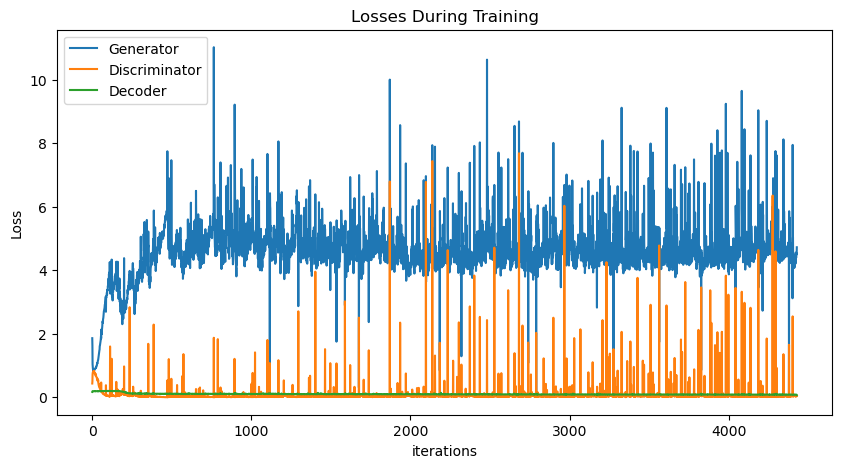

## Generated images with Decoder

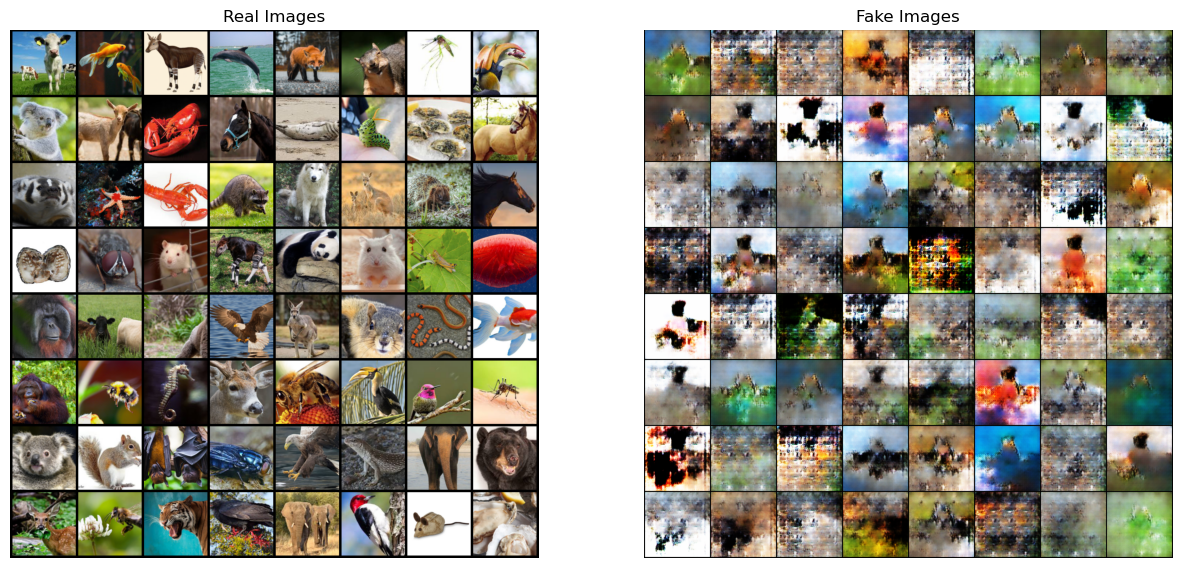

## FID with Decoder
314.047


# MLP classification over decoded vectors

In [ ]:
# Assuming your dataloader provides both images and labels
decoded_vectors = []
labels = []

with torch.no_grad():
    for i, data in enumerate(dataloader):
        real_images, real_labels = data[0].to(device), data[1].to(device)
        
        # Generate latent vectors from real images using decoder
        decoded_latent = netDecoder(real_images).detach().cpu().numpy()
        
        # Reshape the decoded vectors from (batch_size, 128, 1, 1) to (batch_size, 128)
        decoded_latent = decoded_latent.reshape(decoded_latent.shape[0], 128)
        
        # Append to the list of decoded vectors and corresponding labels
        decoded_vectors.append(decoded_latent)
        labels.append(real_labels.cpu().numpy())

# Convert lists to numpy arrays for easier processing
decoded_vectors = np.concatenate(decoded_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(decoded_vectors, labels, test_size=0.2, random_state=42)

# Initialize the MLP classifier

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

# Train the MLP on the decoded vectors
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Classification Accuracy: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.4f}')


Classification Accuracy: 26.48%
F1 Score: 0.2635


# Resnet 50 classifier

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Define hyperparameters
num_classes = len(dataset.classes)  # Number of classes based on your dataset
batch_size = 32
num_epochs = 10
learning_rate = 0.001
workers = 2  # Adjust according to your machine
image_size = 128  # Image size used for resizing

# Create the dataset
dataset = datasets.ImageFolder(root='/home/sriyar/adrl_assignment1/Animals_data/animals/animals',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)  # You can also use resnet32
# Modify the final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
all_preds = []
all_labels = []
sample_images = []  # For visualization

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store images and their corresponding labels and predictions
        sample_images.append((images.cpu(), labels.cpu(), preds.cpu()))
        break  # Remove this if you want to evaluate the entire dataset

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'ResNet Classification Accuracy: {accuracy * 100:.2f}%')
print(f'ResNet F1 Score: {f1:.4f}')

# Visualization of predictions
# Extracting the first batch for visualization
images, labels, preds = sample_images[0]

# Create a grid of images
grid = vutils.make_grid(images[:64], padding=2, normalize=True)
grid = grid.numpy().transpose((1, 2, 0))

# Plotting the images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample Training Images with Predictions")

# Display the images
plt.imshow(grid)
plt.show()

# Display predictions vs actual labels
for i in range(min(10, len(labels))):  # Show first 10 for clarity
    print(f"True: {dataset.classes[labels[i]]}, Predicted: {dataset.classes[preds[i]]}")


Epoch [1/10], Loss: 3.3424
Epoch [2/10], Loss: 2.4407
Epoch [3/10], Loss: 1.3488
Epoch [4/10], Loss: 1.7459
Epoch [5/10], Loss: 1.1754
Epoch [6/10], Loss: 0.4594
Epoch [7/10], Loss: 0.4154
Epoch [8/10], Loss: 0.2966
Epoch [9/10], Loss: 0.2163
Epoch [10/10], Loss: 0.5081
ResNet Classification Accuracy: 93.75%
ResNet F1 Score: 0.9375
